# Cat v Dog CNN

In [77]:
#General
from pathlib import PosixPath
import os
import sys


#Data loading
import numpy as np
from PIL import Image


#Model libraries
import fastai.vision as faiv
import matplotlib.pyplot as plt
from fastai.vision import *

import torchvision
import torch
from torch import nn
from torch.nn.utils import spectral_norm, weight_norm

In [2]:
data_dir = "../../data/dog vs cat"

In [82]:
dev = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on: ", dev)
device = torch.device(dev)

Running on:  cuda


# Data Block API

In [4]:
#class BasicImage(faiv.ItemBase):
#     def __init__(self, path):
#         self.data = open_jpg(path)
        
# class BasicImageList(faiv.ItemList):
#     def __init__(self, items, itemsB=None, **kwargs):
#         super().__init__(items, **kwargs)
#         self.itemsB = itemsB
#         self.copy_new.append('itemsB')
        
#     def get(self, i):
#         path = super().get(i)
#         return BasicImage(path)

In [59]:
def open_jpg(path, size):
    i = Image.open(path)
    i2 = i.resize(size)
    a = np.asarray(i2) / 255
    t = torch.Tensor(a)
    t2 = t.permute(2,0,1)
    image = faiv.open_image(path)
    image = image.resize(128)
    return image
    
class MyImageItemList(faiv.ItemList):
    
    def __init__(self, items, itemsB=None, size=(128,128), **kwargs):
        super().__init__(items, **kwargs)
        self.itemsB = itemsB
        self.copy_new.append('itemsB')
        self.size = size
        
    def get(self, i):
        path = super().get(i)
        return open_jpg(path, self.size)
        
    """ custom item list for nifti files """
    def open(self, fn:faiv.PathOrStr)->faiv.Image: return open_jpg(fn)
    

def get_y_label(x):
    name = x.stem
    label = ""
    for c in name:
        if c != '.':
            label += c
        else:
            break
    return label

# CNN

In [60]:
def conv2d(ni:int, nf:int, ks:int=3, stride:int=2, pad:int=1, norm='batch'):
    bias = not norm == 'batch'
    conv = faiv.init_default(nn.Conv2d(ni,nf,ks,stride,pad,bias=bias))
    conv = spectral_norm(conv) if norm == 'spectral' else weight_norm(conv) if norm == 'weight' else conv
    layers = [conv]
    layers += [nn.ReLU(inplace=True)]  # use inplace due to memory constraints
    layers += [nn.BatchNorm2d(nf)] if norm == 'batch' else []
    return nn.Sequential(*layers)

def res2d_block(ni, nf, ks=3, norm='batch', dense=False):
    """ 2d Resnet block of `nf` features """
    return faiv.SequentialEx(conv2d(ni, nf, ks, pad=ks//2, norm=norm),
                             conv2d(nf, nf, ks, pad=ks//2, norm=norm))


class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

# Playing with Data 

In [61]:
norm = 'batch'
layers = ([res2d_block(1,16,3,norm=norm)]+
        [res2d_block(16,16,norm=norm) for _ in range(4)]+
        [conv2d(16,1,ks=1,pad=0,norm=None)]+
        [Flatten()]+
        [nn.Linear(10813440, 4)])
model = nn.Sequential(*layers)

In [62]:
data_dir = PosixPath('../../data/dog vs cat')
data_dir.ls()

[PosixPath('../../data/dog vs cat/valid'),
 PosixPath('../../data/dog vs cat/train')]

In [81]:
idb = (MyImageItemList.from_folder(data_dir, extensions=('.jpg'))
                    .split_by_folder()
                    .label_from_folder()
                    .databunch(bs=5))

loss = nn.CrossEntropyLoss()
learner = faiv.Learner(idb, model, loss_func=loss)
learner2 = faiv.cnn_learner(idb, models.resnet50)

/home/553592/.conda/envs/hsp/lib/python3.7/site-packages/fastai/basic_data.py:262: UserWarning: There seems to be something wrong with your dataset, for example, in the first batch can't access any element of self.train_ds.
Tried: 5097,4353,7797,6935,4316
  warn(warn_msg)


You can deactivate this warning by passing `no_check=True`.


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/553592/.cache/torch/checkpoints/resnet50-19c8e357.pth


RuntimeError: CUDA error: no kernel image is available for execution on the device

In [67]:
idb

DataBunch;

Train: LabelList (8000 items)
x: MyImageItemList
Image (3, 375, 499),Image (3, 373, 279),Image (3, 305, 409),Image (3, 464, 500),Image (3, 375, 499)
y: CategoryList
cats,cats,cats,cats,cats
Path: ../../data/dog vs cat;

Valid: LabelList (2000 items)
x: MyImageItemList
Image (3, 474, 499),Image (3, 269, 186),Image (3, 374, 500),Image (3, 260, 214),Image (3, 440, 439)
y: CategoryList
cats,cats,cats,cats,cats
Path: ../../data/dog vs cat;

Test: None

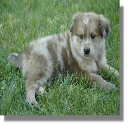

In [72]:
idb.train_ds.x[7009]

# Training

In [66]:
learner.summary()

RuntimeError: Given groups=1, weight of size 16 1 3 3, expected input[1, 3, 128, 128] to have 1 channels, but got 3 channels instead